setup a dataset, do one fusion step, render

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from grid_fusion_pytorch.dataset import PointCloudDataset, CustomCollate
from apex import amp
import time
import sys
import os
import shutil
from tqdm.auto import tqdm
from pprint import pprint

import torch_scatter
from grid_fusion_pytorch.render import render_grids, batch_fuse_to_grid
from moviepy import editor as mpy


import sys

import warnings 
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("default")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap_39 = torch.tensor([[188,143,143],    # master_chef_can -  0
                        [161,203,242],    # cracker_box -  1
                        [227,88,34],      # sugar_box -  2
                        [240,128,128],    # tomato_soup_can -  3
                        [247,167,0],      # mustard_bottle -  4
                        [0,191,255],      # tuna_fish_can -  5
                        [102,205,170],    # pudding_box -  6
                        [255,69,0],       # gelatin_box -  7
                        [100,68,34],      # potted_meat_can -  8
                        [243,195,0],      # banana -  9
                        [252,90,141],     # strawberry - 10
                        [154,191,89],     # apple - 11
                        [252,227,190],    # peach - 12
                        [81,59,75],       # plum - 13
                        [100,149,237],    # pitcher_base - 14
                        [137,44,22],      # bleach_cleanser - 15
                        [0,100,0],        # bowl - 16
                        [219,210,0],      # mug - 17
                        [179,68,108],     # sponge - 18
                        [41,183,0],       # spatula - 19
                        [96,78,151],      # power_drill - 20
                        [249,147,120],    # wood_block - 21
                        [205,133,63],     # scissors - 22
                        [0,255,0],        # large_marker - 23
                        [255,0,0],        # adjustable_wrench - 24
                        [255,165,0],      # flat_screwdriver - 25
                        [199,21,133],     # hammer - 26
                        [0,250,154],      # medium_clamp - 27
                        [0,103,166],      # extra_large_clamp - 28
                        [230,143,172],    # softball - 29
                        [223,255,79],     # tennis_ball - 30
                        [139,0,139],      # racquetball - 31
                        [0,136,85],       # golf_ball - 32
                        [0,0,255],        # foam_brick - 33
                        [132,132,130],    # dice - 34
                        [240,128,128],    # colored_wood_blocks - 35
                        [195,179,129],    # toy_airplane - 36
                        [0,255,255],      # rubiks_cube - 37
                        [191,0,50]])/255. # red_box - 38

In [3]:
# x and y axis probably still buggy
def get_orbit_world_cam(n_steps=100, r=1., h=0., axis='z', look_at=np.zeros(3)):
    phis = np.linspace(0, 2*np.pi, n_steps)[::-1]
    hs   = h * np.ones_like(phis)
    x = r * np.cos(phis)
    y = r * np.sin(phis)
    z = hs
    if axis == 'z':
        orbit = np.stack([x,y,z]).T
    elif axis == 'y':
        orbit = np.stack([x,z,y]).T
    elif axis == 'x':
        orbit = np.stack([z,x,y]).T
    orbit += look_at
    z_cam = (look_at - orbit)
    z_cam /= np.linalg.norm(z_cam, axis=-1, keepdims=True)
    
    x_cam = np.cross(z_cam, np.array([0., 0., -1.]))
    
    y_cam = np.cross(x_cam, z_cam)
    
    world_cam = np.zeros((n_steps, 4, 4))
    world_cam[:,:3,0] = -x_cam # maybe some bug here, image is mirrored
    world_cam[:,:3,1] = y_cam 
    world_cam[:,:3,2] = z_cam
    world_cam[:,:3,-1] = orbit
    
    world_cam[:,-1,-1] = 1
    
    world_cam_pt = torch.from_numpy(world_cam).float()
    #world_cam_pt[:,:3,:3] = world_cam_pt[:,:3,:3].permute(0,2,1)
    #world_cam_pt[:,:3,-1] = (world_cam_pt[:,:3,:3] @ world_cam_pt[:,:3,-1].unsqueeze(-1)).squeeze(-1)
    return world_cam_pt

@torch.no_grad()
def render_orbit(grids, grid_config, cam_k, scale=1., grid_idx=0, cam_idx=0, n_steps=100, r=1.5, h=0., axis='z', n_points=100, look_at=np.array([0,0,0.9]), max_chunksize=1000000):
    render_grid = grids[grid_idx:grid_idx+1]
    world_cam = get_orbit_world_cam(n_steps, r, h, axis, look_at).to(render_grid.device).unsqueeze(1)
    #for item in world_cam:
    #    print(item)
    cx = cam_k[grid_idx, cam_idx, 0, 2]
    cy = cam_k[grid_idx, cam_idx, 1, 2]
#    scale_matrix = torch.tensor([[scale, 0, 0.5*scale-0.5],
#                                 [0, scale, 0.5*scale-0.5],
#                                 [0, 0, 1]], device=render_grid.device)
    scale_matrix = torch.tensor([[scale, 0, scale],
                                 [0, scale, scale],
                                 [0, 0, 1]], device=render_grid.device)
    render_cam_k = scale_matrix[None,None] * cam_k[grid_idx:grid_idx+1, cam_idx:cam_idx+1]
    H, W = int(2*cy), int(2*cx)
    renders, renders_depth, trs = [], [], []
    for i in range(n_steps):
        r, rd, tr, _, _ = render_grids(render_grid, grid_config, world_cam[i:i+1], render_cam_k, n_points=n_points, H=H, W=W)
        renders.append(r.cpu())
        renders_depth.append(rd.cpu())
        trs.append(tr.cpu())
        del r, rd, tr
    return torch.stack(renders).squeeze().permute(0,2,1).view(n_steps,-1,H,W), torch.stack(renders_depth).squeeze().view(n_steps,H,W), torch.stack(trs).squeeze().view(n_steps,H,W)

In [4]:
# semseg: batch_size x n_cams x h * w x 1
# out: batch_size x n_cams x h * w x C
def soften_semseg(semseg, eps=1e-4, num_classes=None):
    if num_classes is None:
        num_classes = semseg.max().item() + 1
    semseg_delta = torch.eye(num_classes).to(semseg.device)[semseg]
    # finally soften delta peaks
    ret = torch.where(semseg_delta == 0, torch.ones_like(semseg_delta)*eps, torch.ones_like(semseg_delta)-(num_classes-1)*eps)
    return ret

In [5]:
MODE = 'normal'
DATASET_NAME = 'overfit_O39_S1_C32_pcd_' + MODE #'proto_refine_pcd'
NUM_CAMS = -1
BATCH_SIZE = 1
INSPECT_SHAPES = True
RANDOM_PCD = False

# create a dummy dataset and showcase dataloading
test_dataset = PointCloudDataset(root='/home/nfs/inf6/data/datasets/semantic_pcd_data/'+DATASET_NAME, split='full',
                                 num_steps=-1, num_cams=NUM_CAMS, random_pcd=RANDOM_PCD, cam_world=False)
if INSPECT_SHAPES:
    print('Length of test_dataset:', len(test_dataset), '\n')

# look at the data returned by this dataset
if INSPECT_SHAPES:
    test_output = test_dataset.__getitem__(0)
    pcd, semseg, cam_pose, depth, cam_k, gt = test_output
    print('Dataset __getitem__ output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape, '\n')
    print('pcd element shapes:')
    for item in pcd:
        print(item.shape)
    print()

# define a collate function and a dataloader
collate = CustomCollate(min_num_steps=1, max_num_steps=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
# look at the output shapes of each minibatch
if INSPECT_SHAPES:
    for pcd, semseg, cam_pose, depth, cam_k, gt in test_dataloader:
        print('Minibatch output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape)
        print('pcd batched element shapes:')
        for item in pcd:
            print(item.shape)
    print()

# example for adapting the maximum number of fusion/refinement steps
if INSPECT_SHAPES:
    test_dataloader.collate_fn.set_steps(1, 6)
    for pcd, semseg, cam_pose, depth, cam_k, gt in test_dataloader:
        print('Minibatch output len/shapes:\n', len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape, gt.shape)
        print('pcd batched element shapes:')
        for item in pcd:
            print(item.shape)

Length of test_dataset: 1 

Dataset __getitem__ output len/shapes:
 6 torch.Size([22, 1, 480, 640]) torch.Size([22, 4, 4]) torch.Size([22, 1, 480, 640]) torch.Size([22, 3, 3]) torch.Size([2122936, 42]) 

pcd element shapes:
torch.Size([188719, 42])
torch.Size([95493, 42])
torch.Size([93658, 42])
torch.Size([42648, 42])
torch.Size([212162, 42])
torch.Size([36941, 42])

Minibatch output len/shapes:
 1 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3]) torch.Size([1, 2122936, 42])
pcd batched element shapes:
torch.Size([1, 188719, 42])

Minibatch output len/shapes:
 3 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3]) torch.Size([1, 2122936, 42])
pcd batched element shapes:
torch.Size([1, 188719, 42])
torch.Size([1, 95493, 42])
torch.Size([1, 93658, 42])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
dtype = torch.float32

VERBOSE = True
VIS = True
RENDER = True
N_STEPS = 3
EPS = 6e-1

#remap_cuda = remap.to(device)

voxel_grid_config = np.load('voxel_grid_config.npy', allow_pickle=True).item()

print('Channels:', voxel_grid_config['channels'])
print('World size:', voxel_grid_config['world_size'])
print('Voxel size:', voxel_grid_config['voxel_size'])
if voxel_grid_config['use_pos_enc']:
    print('Positional encoding shape:', voxel_grid_config['pos_enc'].shape)
print()

# renderer setup
N_RAYS = -1
N_POINTS = 192


##### train
best_loss = 1e25
test_dataloader.collate_fn.set_steps(N_STEPS, N_STEPS)
data_loader_items = list(iter(test_dataloader))
pcd, semseg, cam_pose, depth, cam_k, gt = data_loader_items[0]
semseg, cam_pose, depth, cam_k = semseg.to(device), cam_pose.to(device), depth.to(device), cam_k.to(device)
#semseg = remap_cuda[semseg]
if VERBOSE:
    print('DATA LOADING')
    print('Minibatch output len/shapes\n', 'len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape')
    print(len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape)
    print()

##### FUSION STEP
if VERBOSE:
    print('FUSION STEP')
grid_batch = None
grid_batch_refined = None
for k, point_cloud_batch in enumerate(pcd[-1:]):
    if VERBOSE:
        print('Point cloud batch shape:', point_cloud_batch.shape)
    # fuse voxels
    with torch.no_grad():
        grid_batch = batch_fuse_to_grid(point_cloud_batch.to(device), grid_batch,
                                        world_size=voxel_grid_config['world_size'],
                                        channels=voxel_grid_config['channels'],
                                        range_min=voxel_grid_config['range_min'],
                                        range_max=voxel_grid_config['range_max'],
                                        density_step=voxel_grid_config['density_factor']*voxel_grid_config['voxel_size'])
with torch.no_grad():
    # switch to probabilities
    grid_batch_unrefined = torch.cat([grid_batch[:,:1], torch.exp(grid_batch[:,1:-1]), grid_batch[:,-1:]], dim=1)

print('Grid shapes:', grid_batch.shape, grid_batch_unrefined.shape)

Using device: cuda
Channels: 39
World size: tensor([140, 112, 100])
Voxel size: tensor(0.0101)

DATA LOADING
Minibatch output len/shapes
 len(pcd), semseg.shape, cam_pose.shape, depth.shape, cam_k.shape
3 torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3])

FUSION STEP
Point cloud batch shape: torch.Size([1, 93658, 42])
Grid shapes: torch.Size([1, 41, 140, 112, 100]) torch.Size([1, 41, 140, 112, 100])


renders, renders_depth, trs = render_orbit(grid_batch_unrefined.half(), voxel_grid_config, cam_k,  
                                           r=0.9, h=1., n_steps=300, n_points=N_POINTS, axis='z', 
                                           look_at=np.array([0,0,0.92]), max_chunksize=100000000)

render_vis = cmap_39[renders.argmax(1).squeeze()]

background_render = torch.abs(trs - 1) <= 0

render_vis[background_render] = torch.zeros(3).to(render_vis.device)

render_vis_np = (255*render_vis).byte().numpy()

clip = mpy.ImageSequenceClip([item for item in render_vis_np], fps=30)

clip.ipython_display()

In [7]:
semseg_dummy, cam_pose_dummy, depth_dummy, cam_k_dummy = semseg[:,:], cam_pose[:,:], depth[:,:], cam_k[:,:]
print('Dummy input shapes:', semseg_dummy.shape, cam_pose_dummy.shape, depth_dummy.shape, cam_k_dummy.shape)

# TODO N_SCENES = ... and then stack these dummy objects accordingly

B = depth_dummy.shape[0]
H, W, D = 140, 112, 100
n_misses = torch.zeros([B, 2, H, W, D]).to(device)
print('Miss counter shape:', n_misses.shape)

Dummy input shapes: torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 4, 4]) torch.Size([1, 22, 1, 480, 640]) torch.Size([1, 22, 3, 3])
Miss counter shape: torch.Size([1, 2, 140, 112, 100])


In [8]:
from grid_fusion_pytorch.render import sample_rays

ray_origs, ray_dirs, semseg_out, depth_out = sample_rays(cam_pose_dummy, cam_k_dummy, depth=depth_dummy)
depth_out = depth_out.squeeze(-1)
range_max, range_min = voxel_grid_config['range_max'][:3].to(device), voxel_grid_config['range_min'][:3].to(device)
print(ray_origs.shape, ray_dirs.shape, semseg_out, depth_out.shape, range_min.shape, range_max.shape)

torch.Size([1, 22, 3]) torch.Size([1, 22, 307200, 3]) None torch.Size([1, 22, 307200]) torch.Size([3]) torch.Size([3])


In [9]:
semseg_reshape = semseg.squeeze(2).flatten(-2,-1)
print(semseg_reshape.shape)
semseg_soft = torch.log(soften_semseg(semseg_reshape))
semseg_soft[semseg_reshape == -1] = torch.ones(semseg_soft.shape[-1]).to(semseg_soft.device)
print(semseg_soft.shape)
print(torch.exp(semseg_soft[0,0,0]).sum())
print(semseg_soft.min(), semseg_soft.max())

torch.Size([1, 22, 307200])
torch.Size([1, 22, 307200, 39])
tensor(106.0130, device='cuda:0')
tensor(-9.2103, device='cuda:0') tensor(1., device='cuda:0')


In [10]:
from lib.counting_model import apply_counting_model

out = apply_counting_model(n_misses, ray_origs, ray_dirs, depth_out, range_min, range_max)
print(out.shape)

Using /home/nogga/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nogga/.cache/torch_extensions/py38_cu118/counting_model_util_cuda/build.ninja...
Building extension module counting_model_util_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=counting_model_util_cuda -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.8/dist-packages/torch/include -isystem /usr/local/lib/python3.8/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.8/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.8/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_75,code=sm_75 -gencode=arch=compute_80,code=sm_80 -gencode=arch=compute_86,code=sm_86 -gencode=arc

Loading extension module counting_model_util_cuda...


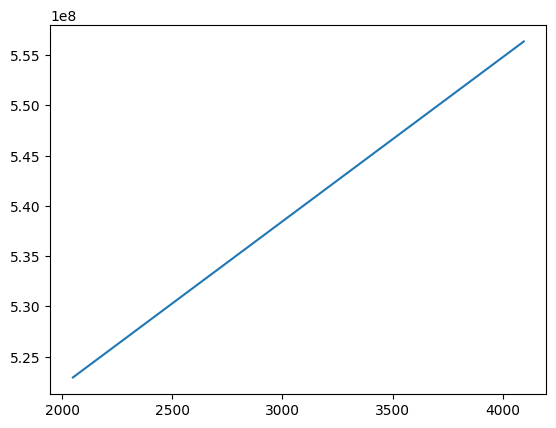

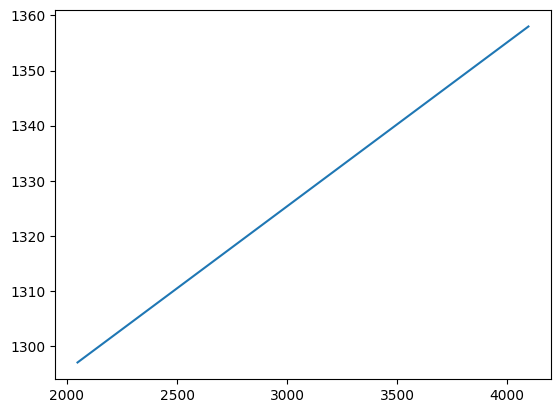

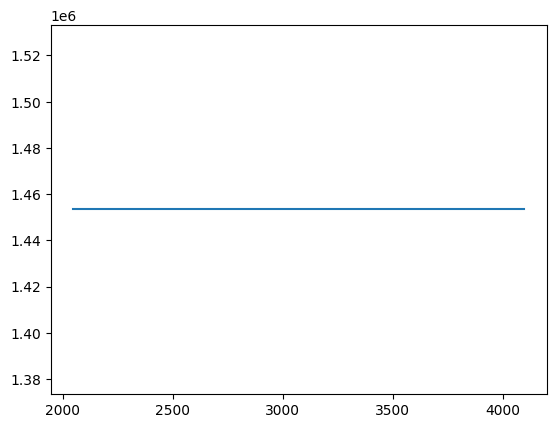

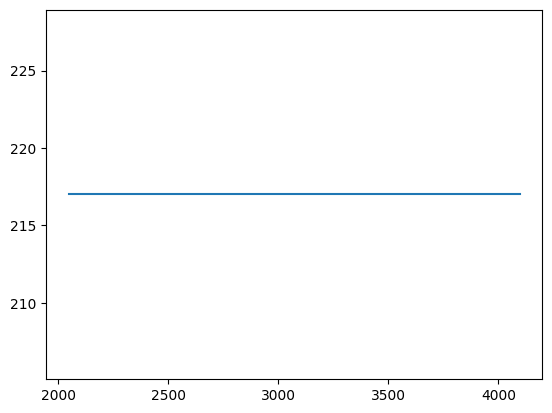

In [11]:
miss_sum_hist, miss_max_hist = [], []
hit_sum_hist, hit_max_hist = [], []
#n_steps = np.array([16, 64, 256, 1024, 2048, 4096, 8192, 16384, 32768])
n_steps = np.array([2048, 4096])
for steps in n_steps:
    out = apply_counting_model(n_misses, ray_origs, ray_dirs, depth_out, range_min, range_max, Semseg=semseg_soft, n_steps=steps)
    out_miss = out[:,0]
    out_hit = out[:,1]
    miss_sum_hist.append(out_miss.sum().cpu().item())
    miss_max_hist.append(out_miss.max().cpu().item())
    hit_sum_hist.append(out_hit.sum().cpu().item())
    hit_max_hist.append(out_hit.max().cpu().item())
plt.plot(n_steps, np.array(miss_sum_hist))
plt.show()
plt.plot(n_steps, np.array(miss_max_hist))
plt.show()
plt.plot(n_steps, np.array(hit_sum_hist))
plt.show()
plt.plot(n_steps, np.array(hit_max_hist))
plt.show()

In [12]:
print(n_misses.sum())
print(out_miss.sum(), out_miss.min(), out_miss.max())
print(out_hit.sum(), out_hit.min(), out_hit.max())

tensor(0., device='cuda:0')
tensor(5.5636e+08, device='cuda:0') tensor(0., device='cuda:0') tensor(1358., device='cuda:0')
tensor(1453315., device='cuda:0') tensor(0., device='cuda:0') tensor(217., device='cuda:0')


In [13]:
from matplotlib import animation
from IPython.display import HTML

def animate_slice(counter, title='untitled', mode='w', fps=20, blit=True, vmax=128):
    fig = plt.figure()
    plt.axis('off')
    if mode == 'w':
        out_slice_w = counter[0,-1,:,:]
        im=plt.imshow(out_slice_w.cpu().flip(-1).T,cmap='Greys', vmin=0, vmax=vmax)
        frames = counter.shape[-3]
        def init():
            im.set_data(out_slice_w.cpu().flip(-1).T)
            return [im]
        def animate(i):
            out_slice_w = counter[0,-(i+1),:,:]
            im.set_array(out_slice_w.cpu().flip(-1).T)
            return [im]
    elif mode == 'h':
        out_slice_h = counter[0,:,-1,:]
        im=plt.imshow(out_slice_h.cpu().flip(-1).T,cmap='Greys', vmin=0, vmax=vmax)
        frames = counter.shape[-2]
        def init():
            im.set_data(out_slice_h.cpu().flip(-1).T)
            return [im]
        def animate(i):
            out_slice_h = counter[0,:,-(i+1),:]
            im.set_array(out_slice_h.cpu().flip(-1).T)
            return [im]
    else:
        out_slice_d = counter[0,:,:,-1]
        im=plt.imshow(out_slice_d.cpu().T,cmap='Greys', vmin=0, vmax=vmax)
        frames = counter.shape[-1]
        def init():
            im.set_data(out_slice_d.cpu().T)
            return [im]
        def animate(i):
            out_slice_d = counter[0,:,:,-(i+1)]
            im.set_array(out_slice_d.cpu().T)
            return [im]
    #print(frames)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=20, blit=blit)
    anim.save('slice_'+title+'_'+mode+'.gif', fps=fps)
    plt.close()
    return None

In [14]:
print(out_hit.shape, out_miss.shape)
def calc_reflect_prob(hits, misses):
    return torch.where(hits > 0, hits/(hits + misses), 0)
p_reflect = calc_reflect_prob(out_hit, out_miss)
print(p_reflect.shape, p_reflect.min(), p_reflect.max(), p_reflect.mean())

torch.Size([1, 140, 112, 100]) torch.Size([1, 140, 112, 100])
torch.Size([1, 140, 112, 100]) tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0.0093, device='cuda:0')


In [15]:
cat_dims = [-2, -3, -3]
for i, mode in enumerate(['w', 'h', 'd']):
    animate_slice(torch.cat([out_hit, out_miss, p_reflect], dim=cat_dims[i]), title='counter', mode=mode, fps=5, vmax=1.)

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [16]:
print(torch.logical_and(out_miss > 0,out_hit > 0).sum())
print(torch.logical_and(out_miss > 0,out_hit == 0).sum())
print(torch.logical_and(out_miss == 0,out_hit > 0).sum())

tensor(73555, device='cuda:0')
tensor(1419156, device='cuda:0')
tensor(1877, device='cuda:0')


torch.Size([1, 22, 1, 480, 640])
tensor(-1) tensor(38)


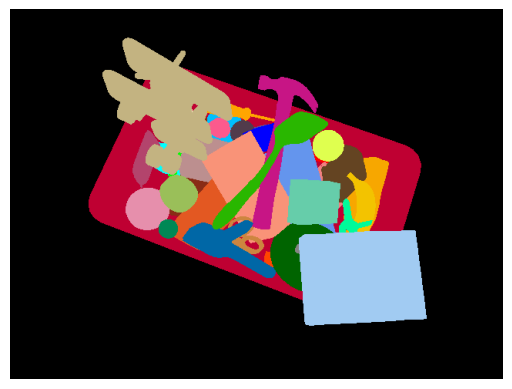

In [17]:
print(semseg_dummy.shape)
semseg_example = semseg_dummy[0,10,0].cpu()
print(semseg_example.min(), semseg_example.max())
semseg_rgb = cmap_39[semseg_example]
semseg_rgb[semseg_example == -1] = torch.zeros(3)
plt.imshow(semseg_rgb)
plt.axis('off')
plt.show()

In [18]:
map_in = torch.zeros([B, 2 + 39, H, W, D]).to(device)
map_in[:,2:] = 1 / (map_in.shape[1]-2)
map_in[:,2:] = torch.log(map_in[:,2:])
map_out = apply_counting_model(map_in, ray_origs, ray_dirs, depth_out, range_min, range_max, Semseg=semseg_soft, n_steps=4096, verbose=True)
print(map_out.shape)
print(torch.allclose(map_in[:,2:], map_out[:,2:]))
print(torch.allclose(map_in[:,:2], map_out[:,:2]))

torch.Size([1, 41, 140, 112, 100])
True
False


In [19]:
# TODO:
# include Bayes filter in cuda kernel
# sanity-check for scene batch size > 1
# time everything
# document apply counting model